In [99]:
# import libraries
import numpy as np
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.utils.class_weight import compute_sample_weight

import warnings
warnings.filterwarnings('ignore')
from sklearn.tree import DecisionTreeClassifier



In [1]:

sys.path.append(os.path.abspath('..'))  # So we can import from src

from src.data_loader import load_data

url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/creditcard.csv"

df = load_data(url)
df.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## <center> Dataset Analysis<center/>

Each row in the dataset represents a credit card transaction. As shown above, each row has 31 variables. One variable (the last variable in the table above) is called Class and represents the target variable. Your objective will be to train a model that uses the other variables to predict the value of the Class variable. Let's first retrieve basic statistics about the target variable.

Note: For confidentiality reasons, the original names of most features are anonymized V1, V2 .. V28. The values of these features are the result of a PCA transformation and are numerical. The feature 'Class' is the target variable and it takes two values: 1 in case of fraud and 0 otherwise. For more information about the dataset please visit this webpage: https://www.kaggle.com/mlg-ulb/creditcardfraud.

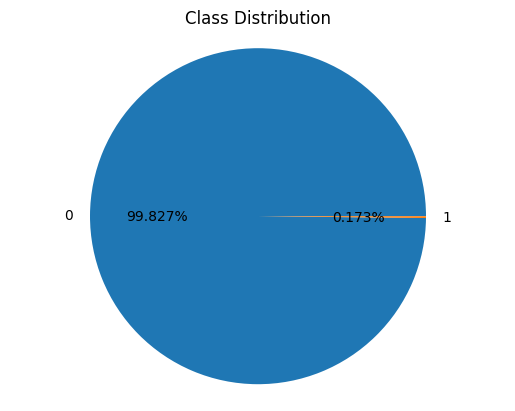

In [37]:
# Get the set of distinct classes
labels = df['Class'].unique()
# Get the count of each class
sizes = df.Class.value_counts().values
# Plot the class distribution
plt.pie(sizes, labels=labels, autopct='%1.3f%%')
plt.axis('equal')
plt.title('Class Distribution')
plt.show()



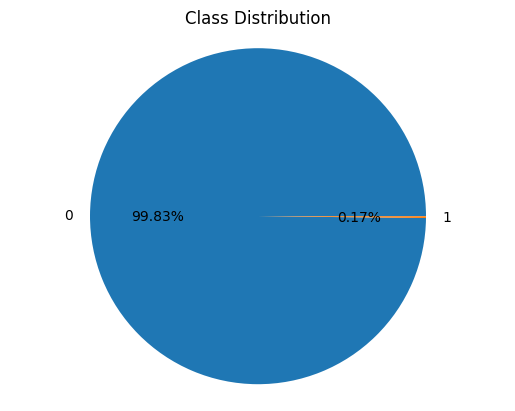

In [47]:
# Plot the class distribution
figure, axx = plt.subplots()
axx.pie(sizes, labels = labels, autopct = '%1.2f%%')
axx.axis('equal')
axx.set_title('Class Distribution')
plt.show()

As shown above, the Class variable has two values: 0 (the credit card transaction is legitimate) and 1 (the credit card transaction is fraudulent). Thus, you need to model a binary classification problem. Moreover, the dataset is highly unbalanced, the target variable classes are not represented equally. This case requires special attention when training or when evaluating the quality of a model. One way of handing this case at train time is to bias the model to pay more attention to the samples in the minority class. The models under the current study will be configured to take into account the class weights of the samples at train/fit time.

It is also prudent to understand which features affect the model in what way. We can visualize the effect of the different features on the model using the code below.

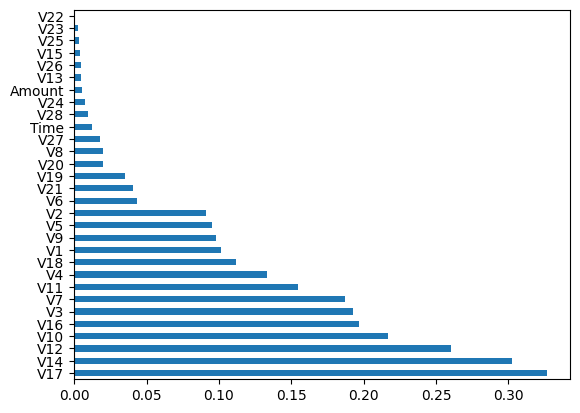

In [58]:
# Effect of the different features on the model
correlation_values = df.corr()['Class'].drop('Class').abs().sort_values(ascending=False)
correlation_values.plot.barh()
plt.show()

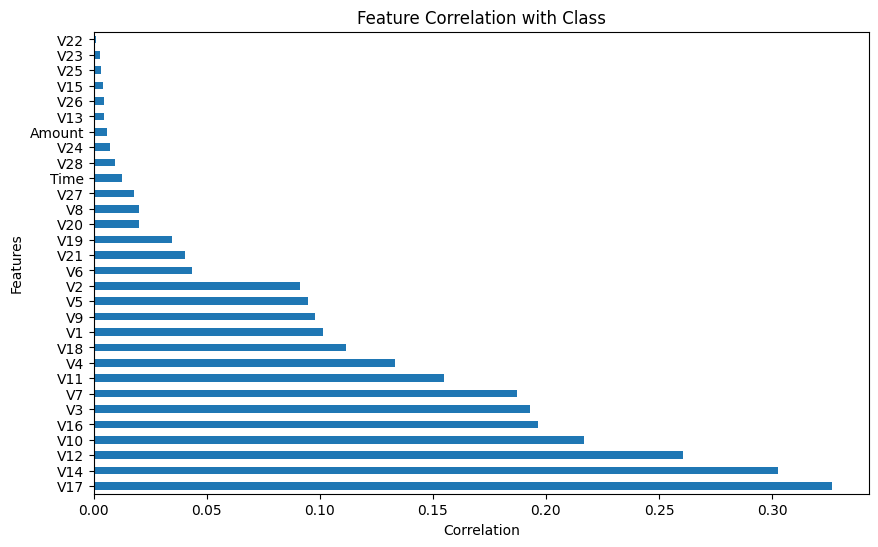

In [67]:
correlation_values.plot(kind='barh', figsize=(10, 6))
plt.title('Feature Correlation with Class')
plt.xlabel('Correlation') 
plt.ylabel('Features')
plt.show()

## <center>Dataset Preprocessing<center/>
I will apply standard scaling to the input features and normalize them using $ L $
 norm for the training models to converge quickly. As seen in the data snapshot, there is a parameter called Time which we will not be considering for modeling. Hence, features 2 to 30 will be used as input features and feature 31, i.e. Class will be used as the target variable.

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [81]:
# standardize features by removing the mean and scaling to unit variance
df.iloc[:, 1:30] = StandardScaler().fit_transform(df.iloc[:, 1:30])
data_matrix = df.values




In [82]:
# X: feature matrix (for this analysis, we exclude the Time variable from the dataset)
X = data_matrix[:, 1:30]
# y: labels vector
y = data_matrix[:, 30]

# Data Normalization
X = normalize(X, norm='l1')

## <center>Dataset Train/Test Split<center/>
Now that the dataset is ready for building the classification models, you need to first divide the pre-processed dataset into a subset to be used for training the model (the train set) and a subset to be used for evaluating the quality of the model (the test set).

In [83]:
# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## <center>Build a Decision Tree Classifier model with Scikit-Learn

In [84]:
# Compute the sample weights to be used as input to the train routine so that it takes into account the class imbalance present in this dataset.
w_train = compute_sample_weight('balanced', y_train)

Using these sample weights, we may train the Decision Tree classifier. We also make note of the time it takes for training this model to compare it against SVM, later in the lab.

In [121]:
dt = DecisionTreeClassifier(max_depth=4, random_state=35)

dt.fit(X_train, y_train, sample_weight=w_train)

,criterion,'gini'
,splitter,'best'
,max_depth,4
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,35
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


## <center>Build a Support Vector Machine model with Scikit-Learn

Unlike Decision Trees, we do not need to initiate a separate sample_weight for SVMs. We can simply pass a parameter in the scikit-learn function.

In [122]:
# for reproducible output across multiple function calls, set random_state to a given integer value
svm = LinearSVC(class_weight='balanced', random_state=31, loss="hinge", fit_intercept=False)

svm.fit(X_train, y_train)

,penalty,'l2'
,loss,'hinge'
,dual,'auto'
,tol,0.0001
,C,1.0
,multi_class,'ovr'
,fit_intercept,False
,intercept_scaling,1
,class_weight,'balanced'
,verbose,0
,random_state,31


## Evaluate the Decision Tree Classifier Models

In [123]:
y_pred_dt = dt.predict_proba(X_test)[:, 1]  # Get the probability of the positive class

In [124]:
y_pred_dt

array([0.98878056, 0.06422603, 0.06422603, ..., 0.06422603, 0.09930896,
       0.06422603], shape=(85443,))

Using these probabilities, we can evaluate the Area Under the Receiver Operating Characteristic Curve (ROC-AUC) score as a metric of model performance. The AUC-ROC score evaluates your model's ability to distinguish positive and negative classes considering all possible probability thresholds. The higher its value, the better the model is considered for separating the two classes of values.

In [126]:
roc_auc_dt = roc_auc_score(y_test, y_pred_dt)
print('Decision Tree ROC-AUC score : {0:.3f}'.format(roc_auc_dt))

Decision Tree ROC-AUC score : 0.939


## <center>Evaluate the Support Vector Machine Model

Run the following cell to compute the probabilities of the test samples belonging to the class of fraudulent transactions.

In [127]:
y_pred_svm = svm.decision_function(X_test)  # Get the decision function scores

You may now evaluate the accuracy of SVM on the test set in terms of the ROC-AUC score.

In [128]:
y_pred_svm 

array([24.56330654, -0.42963895, -1.05986296, ..., -0.51281142,
       -0.26505244, -0.99170395], shape=(85443,))

In [129]:
roc_auc_svm = roc_auc_score(y_test, y_pred_svm)

In [132]:
print(f"SVM ROC-AUC score: {roc_auc_svm:.3f}")

SVM ROC-AUC score: 0.986
